In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import moscot.plotting as mpl
from moscot.problems.cross_modality import TranslationProblem
from moscot.problems.generic import GWProblem
import moscot

import scanpy as sc
import anndata as ad
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing as pp

import time
from tqdm import tqdm
import seaborn as sns
import scib_metrics
import scib
import helper_functions as fcts

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [3]:
def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

In [4]:
import pygsp
import matplotlib
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.patches as mpatches
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

In [5]:
adata = sc.read('data/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')

/dss/dsshome1/01/di93bur/miniconda3/envs/moscot_env_2/lib/python3.9/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/dss/dsshome1/01/di93bur/miniconda3/envs/moscot_env_2/lib/python3.9/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/GEX_pct_counts_mt' was written without encoding metadata.
  return func(*args, **kwargs)
/dss/dsshome1/01/di93bur/miniconda3/envs/moscot_env_2/lib/python3.9/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/GEX_n_counts' was written without encoding metadata.
  return func(*args, **kwargs)
/dss/dsshome1/01/di93bur/miniconda3/envs/moscot_env_2/lib/python3.9/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/GEX_n_genes' was written without encoding metadata.
  return func(*args, **kwargs)
/dss/dsshome1/01/di93bur/miniconda3/envs/moscot_env_2/lib/

In [6]:
atac = adata[:,adata.var_names[adata.var.feature_types.isin(['ATAC'])]]
rna = adata[:,adata.var_names[adata.var.feature_types.isin(['GEX'])]]

In [7]:
results = []

In [8]:
for i in ['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3','s3d6', 's3d7', 's4d1', 's4d8', 's4d9']:
    results.append([i, atac[atac.obs.batch.isin([i])].shape[0], atac[atac.obs.batch.isin([i])].shape[1] , rna[rna.obs.batch.isin([i])].shape[1]])
    

In [9]:
pd.DataFrame(results, columns = ['Site/Donor', '# Samples', '# Peaks', '# Genes'])

Site/Donor  # Samples  # Peaks  # Genes
0        s1d1       6224   116490    13431
1        s1d2       6740   116490    13431
2        s1d3       4279   116490    13431
3        s2d1       4220   116490    13431
4        s2d4       6111   116490    13431
5        s2d5       4895   116490    13431
6       s3d10       6781   116490    13431
7        s3d3       4325   116490    13431
8        s3d6       1679   116490    13431
9        s3d7       1771   116490    13431
10       s4d1       8023   116490    13431
11       s4d8       9876   116490    13431
12       s4d9       4325   116490    13431

# UMAP plot of RNA and ATAC of all batches

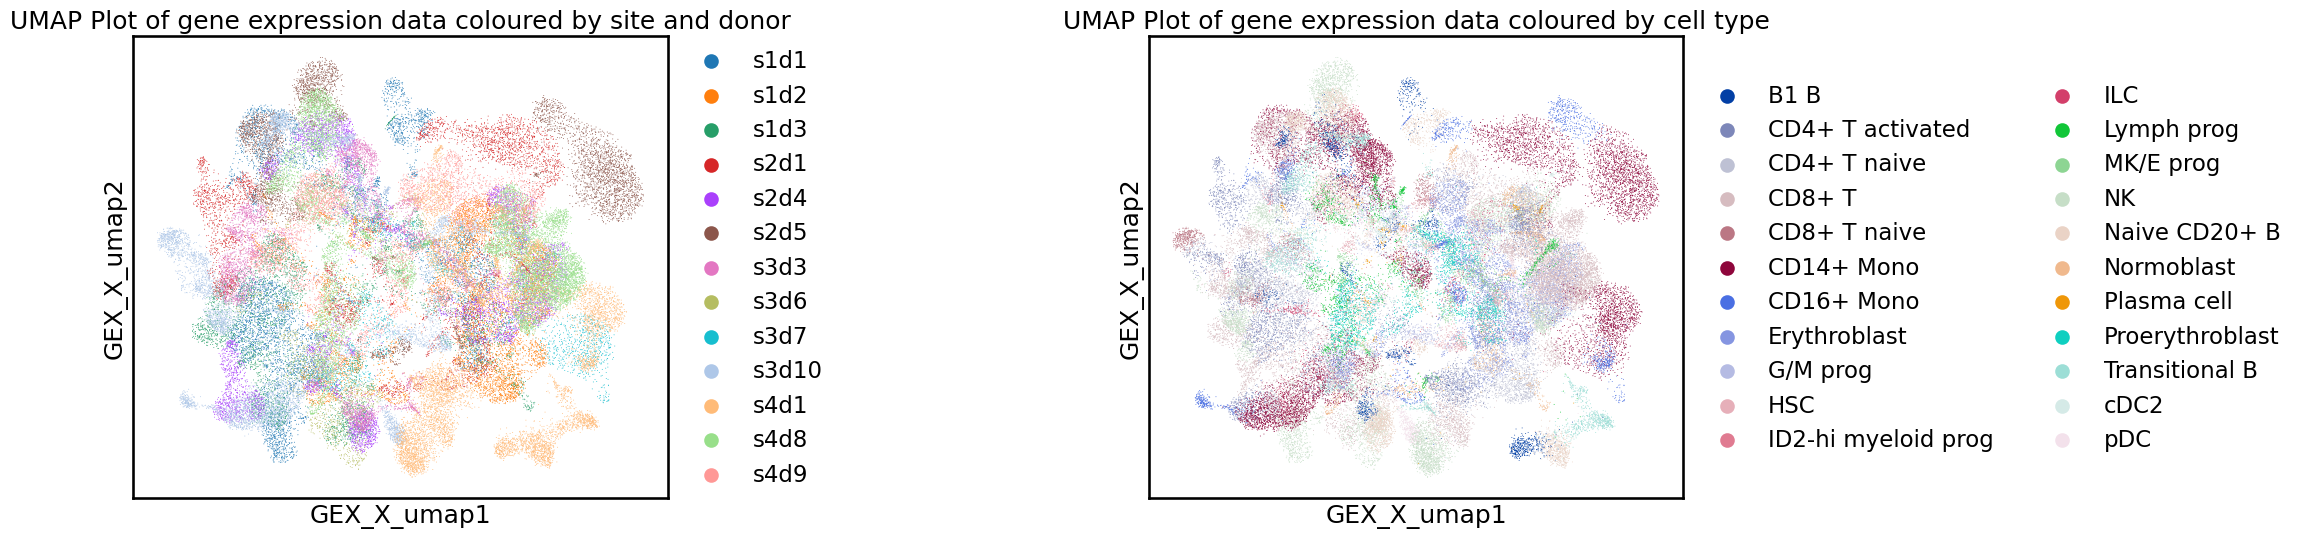

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6), gridspec_kw={'wspace':0.9})
ax1_dict = sc.pl.embedding(adata, basis = 'GEX_X_umap', color =['batch'], ax = ax1, show = False)
ax1_dict.set_title('UMAP Plot of gene expression data coloured by site and donor')
ax2_dict = sc.pl.embedding(adata, basis = 'GEX_X_umap', color =['cell_type'], ax = ax2, show = False)
ax2_dict.set_title('UMAP Plot of gene expression data coloured by cell type')
plt.show()

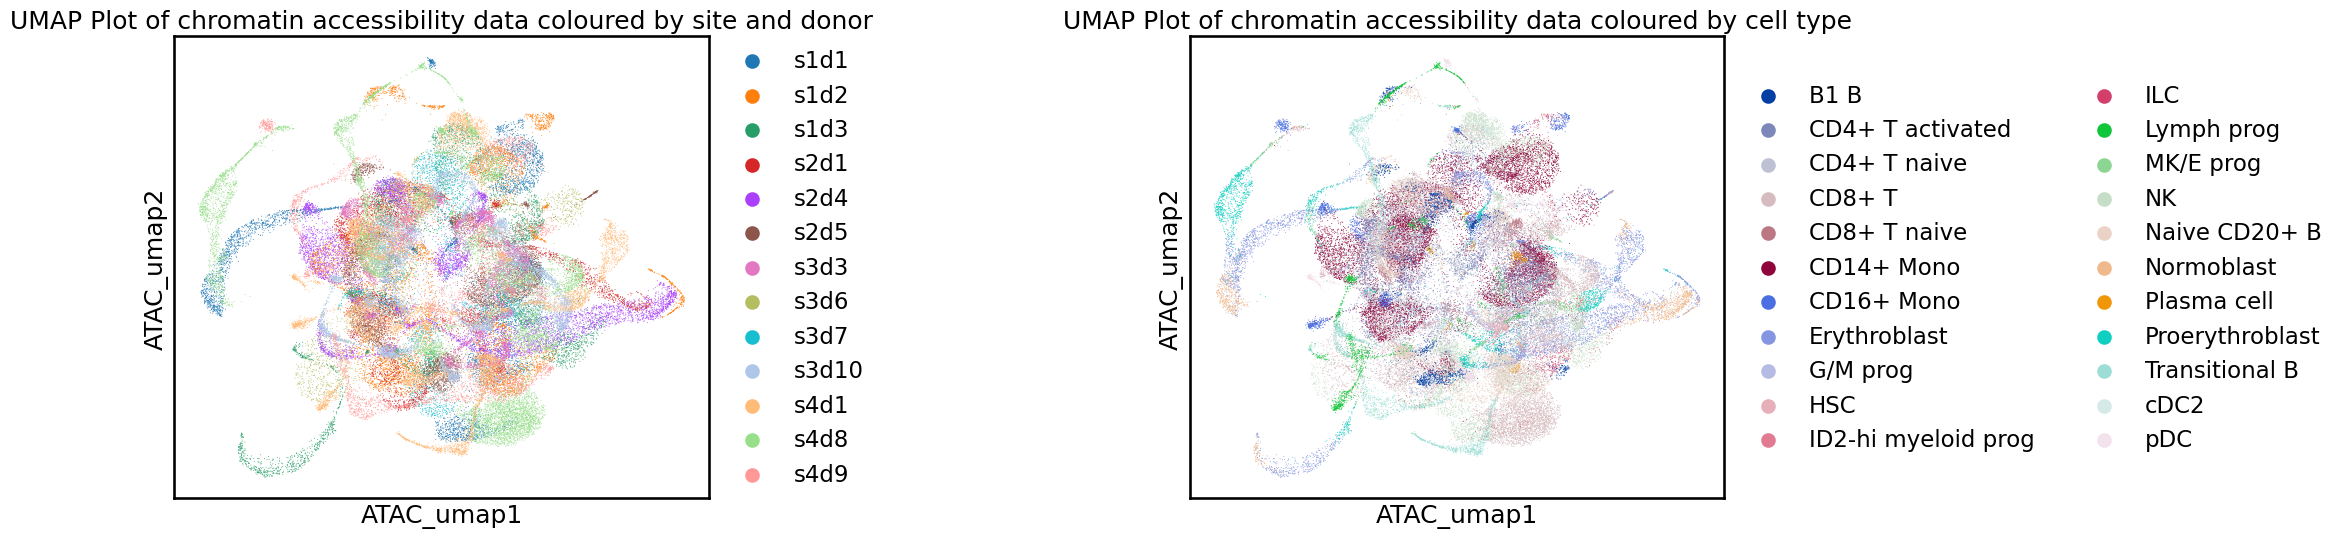

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6), gridspec_kw={'wspace':0.9})
ax1_dict = sc.pl.embedding(adata, basis = 'ATAC_umap', color =['batch'], ax = ax1, show = False)
ax1_dict.set_title('UMAP Plot of chromatin accessibility data coloured by site and donor')
ax2_dict = sc.pl.embedding(adata, basis = 'ATAC_umap', color =['cell_type'], ax = ax2, show = False)
ax2_dict.set_title('UMAP Plot of chromatin accessibility data coloured by cell type')
plt.show()

# UMAP of 4 batches

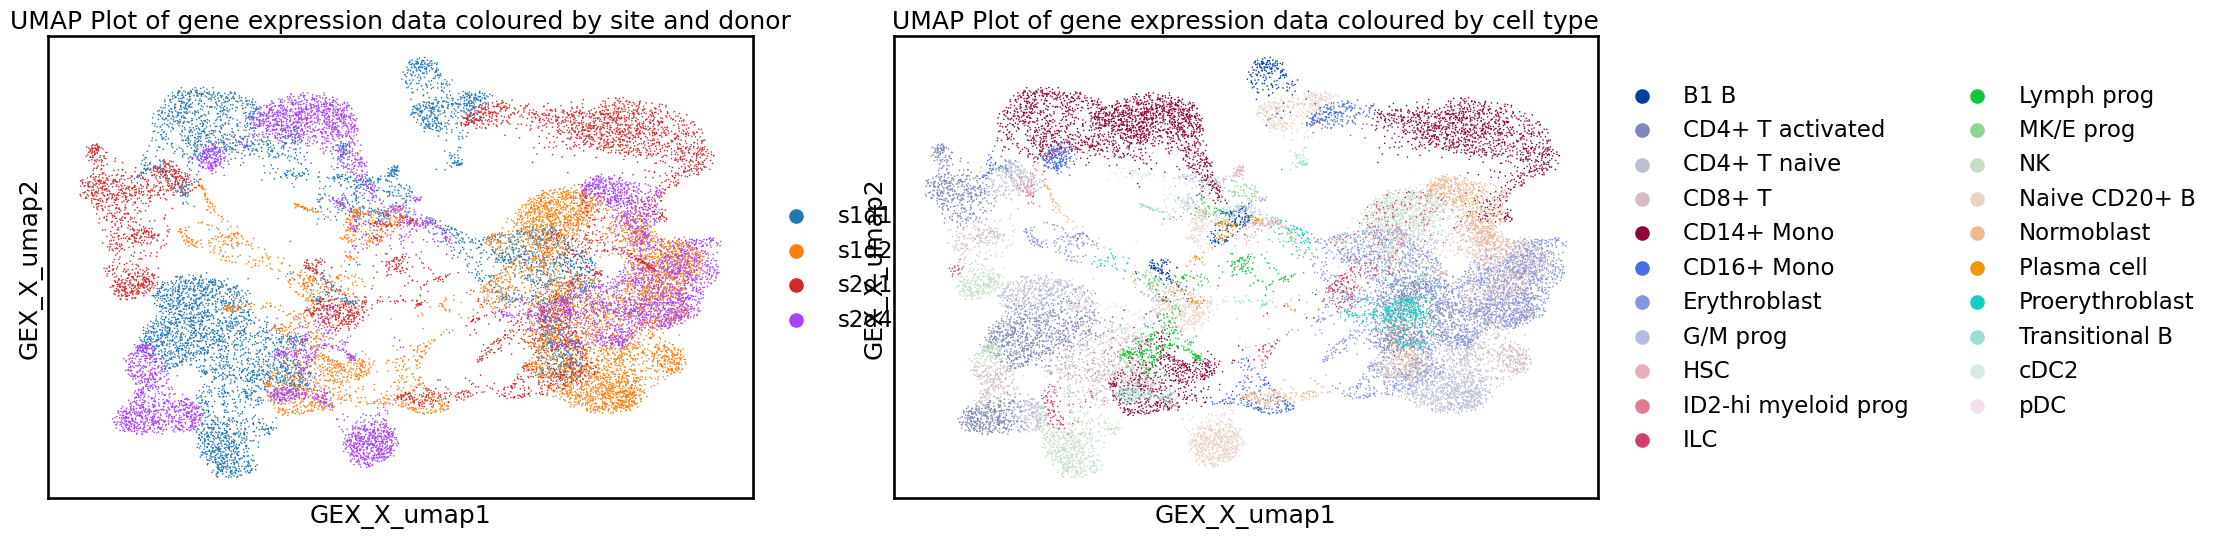

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1_dict = sc.pl.embedding(adata[adata.obs['batch'].isin(['s1d1', 's1d2', 's2d1', 's2d4'])], basis = 'GEX_X_umap', color =['batch'], ax = ax1, show = False)
ax1_dict.set_title('UMAP Plot of gene expression data coloured by site and donor')
ax2_dict = sc.pl.embedding(adata[adata.obs['batch'].isin(['s1d1', 's1d2', 's2d1', 's2d4'])], basis = 'GEX_X_umap', color =['cell_type'], ax = ax2, show = False)
ax2_dict.set_title('UMAP Plot of gene expression data coloured by cell type')
plt.show()

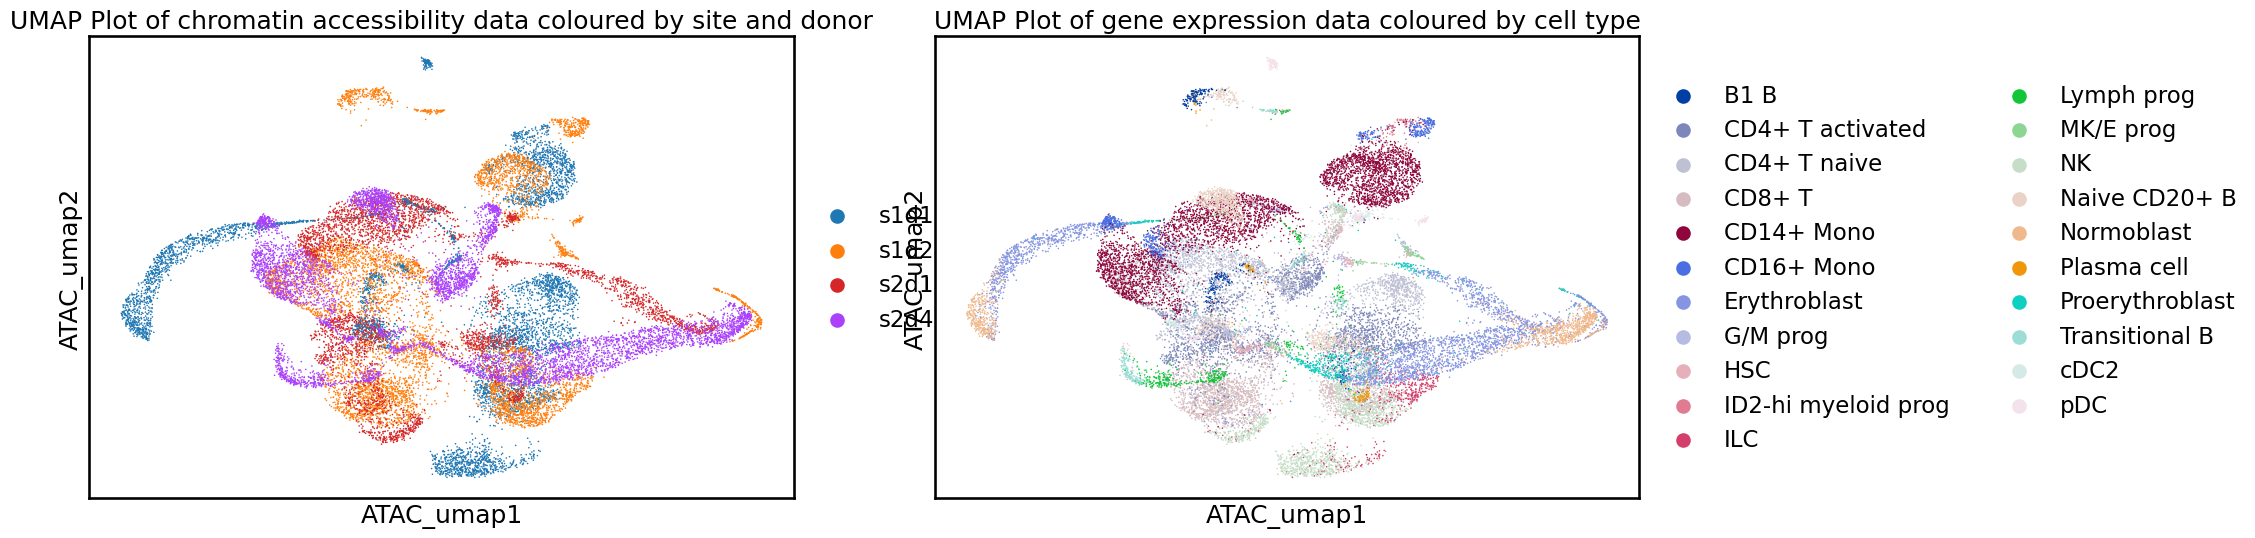

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1_dict = sc.pl.embedding(adata[adata.obs['batch'].isin(['s1d1', 's1d2', 's2d1', 's2d4'])], basis = 'ATAC_umap', color =['batch'], ax = ax1, show = False)
ax1_dict.set_title('UMAP Plot of chromatin accessibility data coloured by site and donor')
ax2_dict = sc.pl.embedding(adata[adata.obs['batch'].isin(['s1d1', 's1d2', 's2d1', 's2d4'])], basis = 'ATAC_umap', color =['cell_type'], ax = ax2, show = False)
ax2_dict.set_title('UMAP Plot of gene expression data coloured by cell type')
plt.show()

# Visualization for S1D1

In [14]:
i = 's1d1'
atac = sc.read('data/'+i+'/atac-emb_gc.h5ad')
rna = sc.read('data/'+i+'/rna-emb_gc.h5ad')
geneactivity = sc.read('data/'+i+'/gene_activity_scvi.h5ad')
rna.obsm['X_pca_norm'] = pp.normalize(rna.obsm['X_pca'])
atac.obsm['X_lsi_norm'] = pp.normalize(atac.obsm['X_lsi_red']) 
rna.obsm['X_scVI_norm'] = pp.normalize(rna.obsm['X_scVI'])
atac.obsm['X_poissonVI_norm'] = pp.normalize(atac.obsm['X_poissonVI'])
rna.obsm['geneactivity'] = geneactivity[geneactivity.obs['batch']=='0'].obsm['X_scVI']
atac.obsm['geneactivity'] = geneactivity[geneactivity.obs['batch']=='1'].obsm['X_scVI']

adata = sc.concat([rna, atac], join = 'outer', label='batch', index_unique = '-')

In [15]:
# Custom Costs
sc.pp.neighbors(geneactivity, use_rep ="X_scVI", key_added="multi_vi", n_neighbors=30)
cell_ids_source = geneactivity[geneactivity.obs['batch']=='0'].obs_names
cell_ids_target = geneactivity[geneactivity.obs['batch']=='1'].obs_names
G = pygsp.graphs.Graph(geneactivity.obsp["multi_vi_connectivities"])
G.estimate_lmax()
filt = pygsp.filters.Heat(G, tau=100)
diffusion_distances = filt.filter(np.eye(len(geneactivity)))
cc_xy = pd.DataFrame(data=-np.log(diffusion_distances[:len(cell_ids_source), len(cell_ids_source):].copy())+1e-15, index=cell_ids_source, columns=cell_ids_target)

sc.pp.neighbors(rna, use_rep = 'X_pca', key_added = "multi_vi", n_neighbors = 30)
G = pygsp.graphs.Graph(rna.obsp["multi_vi_connectivities"])
G.estimate_lmax()
filt = pygsp.filters.Heat(G, tau=100)
diffusion_distances = filt.filter(np.eye(len(rna)))
cell_ids_src = adata[adata.obs['batch']=='0'].obs_names
cc_x_pca = pd.DataFrame(data=-np.log(diffusion_distances.copy())+1e-15, index=cell_ids_src, columns=cell_ids_src)

sc.pp.neighbors(atac, use_rep = 'X_lsi_red', key_added = "multi_vi", n_neighbors = 30)
G = pygsp.graphs.Graph(atac.obsp["multi_vi_connectivities"])
G.estimate_lmax()
filt = pygsp.filters.Heat(G, tau=100)
diffusion_distances = filt.filter(np.eye(len(atac)))
cell_ids_tgt = adata[adata.obs['batch']=='1'].obs_names
cc_y_lsi = pd.DataFrame(data=-np.log(diffusion_distances.copy())+1e-15, index=cell_ids_tgt, columns=cell_ids_tgt)

/dss/dsshome1/01/di93bur/miniconda3/envs/moscot_env_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# UMAP of RNA and ATAC before alignment of S1D1

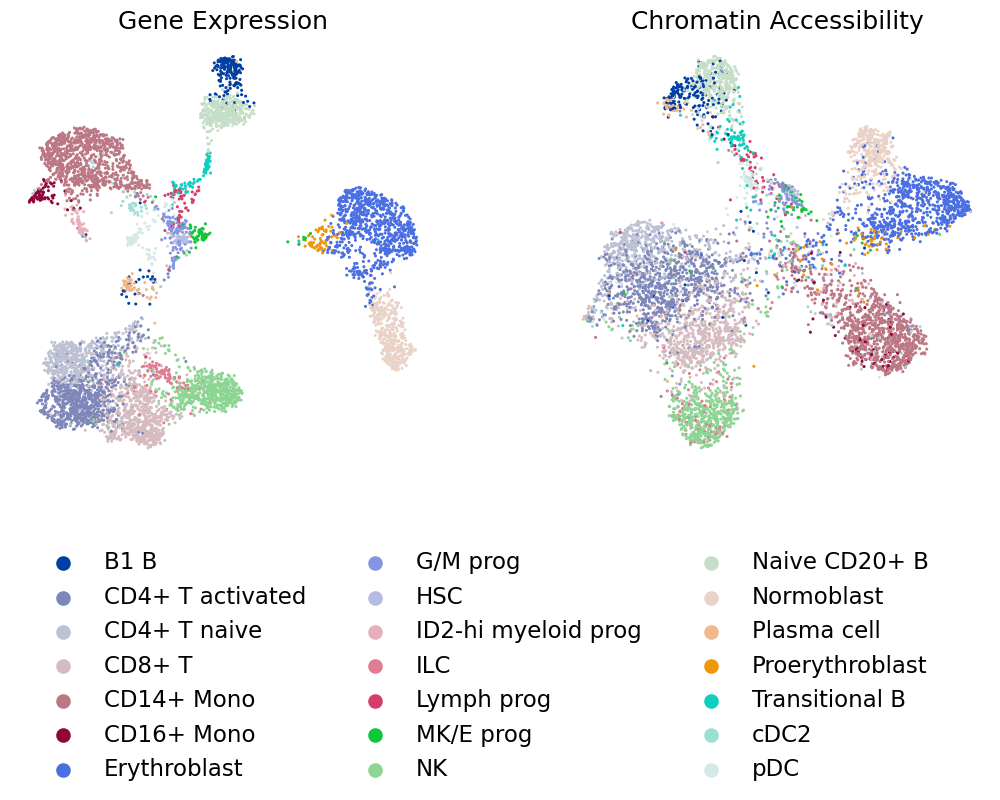

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'wspace': 0.3})

sc.pl.umap(rna, color="cell_type", frameon=False, ax=ax1, show=False)
ax1.set_title("Gene Expression")
ax1.legend().remove()
sc.pl.umap(atac, color="cell_type", frameon=False, ax=ax2, show=False)
ax2.set_title("Chromatin Accessibility")
ax2.legend().remove()

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15), frameon=False)

fig.subplots_adjust(bottom=0.3)
set_size(fig, (10, 8))

plt.savefig('./05_umap_s1d1.png', dpi=300, bbox_inches="tight")
plt.show()

# Solve Gromov-Wasserstein problem

In [17]:
tp = TranslationProblem(rna, atac)
tp = tp.prepare(
    src_attr={"attr": "obsm", "key": 'X_pca_norm'}, 
    tgt_attr={"attr": "obsm", "key": 'X_lsi_norm'}, 
)    
tp = tp.solve( epsilon=1e-3)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(6224, 6224)].                                          


In [18]:
translated_gw = tp.translate('src', 'tgt')

In [19]:
fcts.foscttm(translated_gw, atac.obsm['X_lsi_norm'])

0.3468

# Solve Fused Gromov-Wasserstein problem

In [61]:
ftp = TranslationProblem(rna, atac)
ftp = ftp.prepare(
    src_attr={"attr": "obsm", "key": 'X_pca_norm'}, 
    tgt_attr={"attr": "obsm", "key": 'X_lsi_norm'}, 
    joint_attr = 'geneactivity'
)    
ftp = ftp.solve( epsilon=0.005, alpha = 0.75)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(6224, 6224)].                                          


In [62]:
translated_fgw = ftp.translate('src', 'tgt')
fcts.foscttm(translated_fgw, atac.obsm['X_lsi_norm'])

0.0741

# Visualize Alignments

In [63]:
adata.obsm["X_gw"] = np.concatenate((translated_gw, atac.obsm['X_lsi_norm']), axis=0)
adata.obsm["X_fgw"] = np.concatenate((translated_fgw, atac.obsm['X_lsi_norm']), axis=0)

In [64]:
translation_dict = {'0': 'Gene Expression', '1': 'Chromatin Accessibility'}
adata.obs['batch_translated'] = adata.obs['batch'].map(translation_dict)

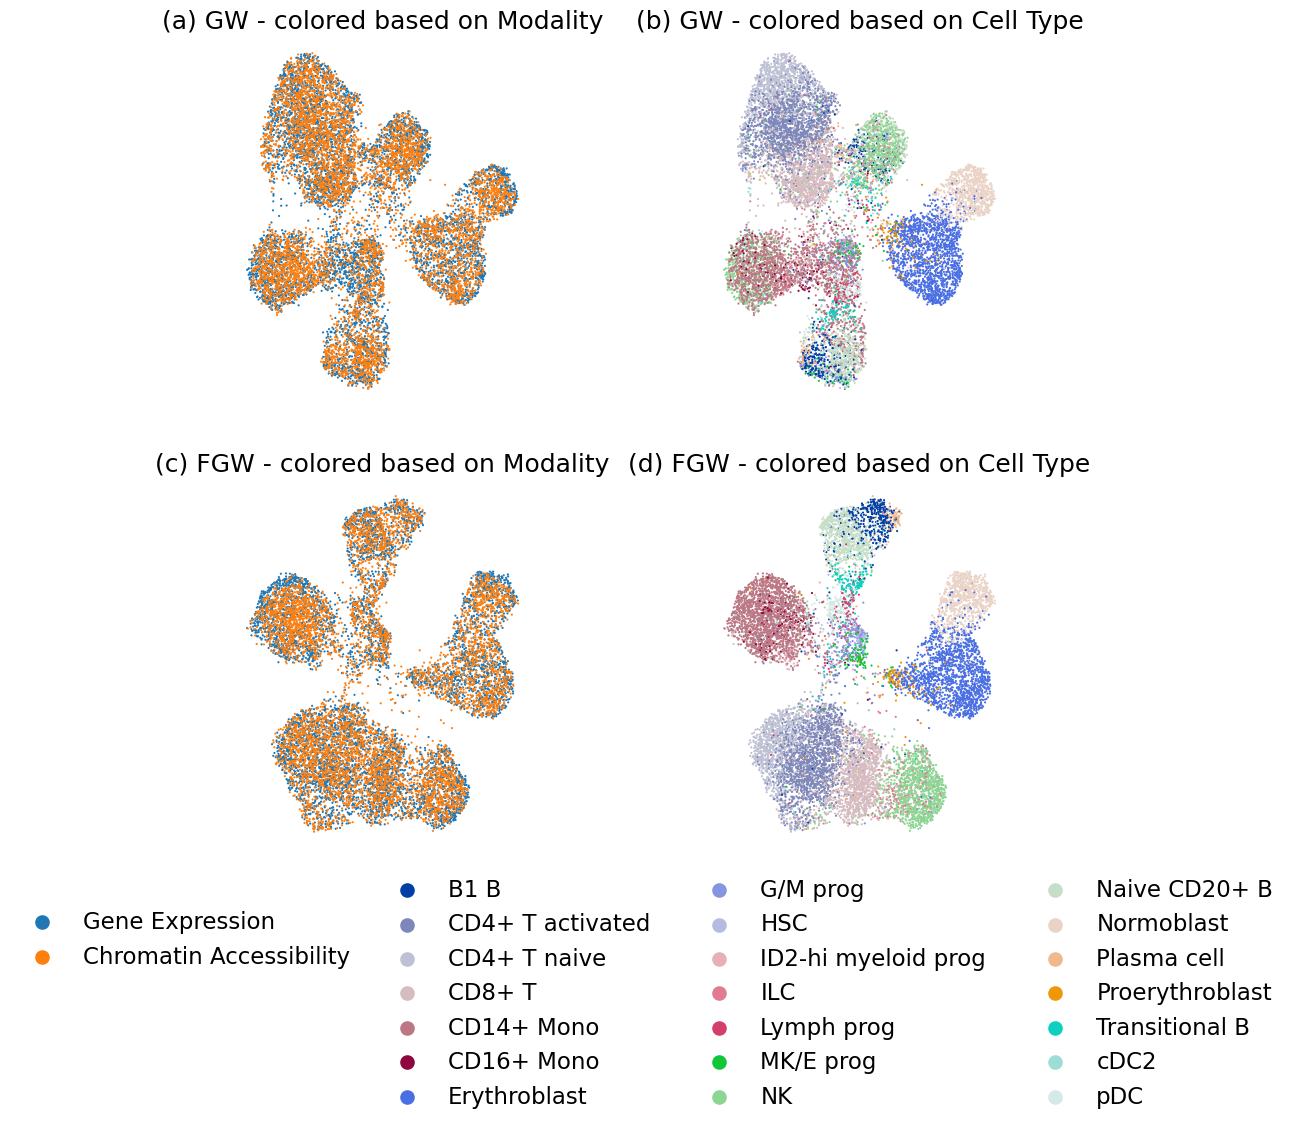

In [32]:
sc.pp.neighbors(adata, use_rep="X_gw")
sc.tl.umap(adata)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'wspace': 0.6})

sc.pl.umap(adata, color=["batch_translated"], frameon=False, ax=ax1, show=False)
ax1.set_title("(a) GW - colored based on Modality")
ax1.get_legend().remove()

sc.pl.umap(adata, color=["cell_type"], frameon=False, ax=ax2, show=False)
ax2.set_title("(b) GW - colored based on Cell Type")
ax2.get_legend().remove()

sc.pp.neighbors(adata, use_rep="X_fgw")
sc.tl.umap(adata)

sc.pl.umap(adata, color=["batch_translated"], frameon=False, ax=ax3, show=False)
ax3.set_title("(c) FGW - colored based on Modality")
ax3.get_legend().remove()

sc.pl.umap(adata, color=["cell_type"], frameon=False, ax=ax4, show=False)
ax4.set_title("(d) FGW - colored based on Cell Type")
ax4.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

fig.legend(handles1, labels1, loc='lower left', ncol = 1, bbox_to_anchor=(-0.11, 0.2), frameon=False,)
fig.legend(handles2, labels2, loc='lower center', ncol=3, bbox_to_anchor=(0.72, 0.1), frameon=False)

fig.subplots_adjust(bottom=0.3)
fig.set_size_inches(10, 14)
plt.savefig('./05_umap_alignment.png', dpi=300, bbox_inches="tight")
plt.show()

# Solve Co-Optimal Transport Problem

In [33]:
import ot
import scipy.io
import sys
sys.path.append('../git_repos/COOT/code')
import cot

In [34]:
xs = pp.normalize(rna.obsm['X_pca'])
xt = pp.normalize(atac.obsm['X_lsi_red']) 

In [35]:
ot.tic()
Ts,Tv,_,log=cot.cot_numpy(xs,xt,niter=50,algo = 'sinkhorn', algo2='sinkhorn', reg=0.001, reg2=0.001, log=True)
ot.toc()

Delta: 0.011696845662163663  Loss: 0.07362875362759039
Delta: 0.039891321552907706  Loss: 0.06869377754288088
Delta: 0.0388498443070155  Loss: 0.06214612306579361
Delta: 0.03701186471731894  Loss: 0.05878116490456542
Delta: 0.035605770382223664  Loss: 0.05634434472696123
Delta: 0.039502082310292216  Loss: 0.054463380167367584
Delta: 0.02823241258016003  Loss: 0.05272028860452946
Delta: 0.01961662844895235  Loss: 0.05195712838445244
Delta: 0.014914449062071452  Loss: 0.05160091969127891
Delta: 0.011581821035210715  Loss: 0.05138429951762746
Delta: 0.010194738736840993  Loss: 0.05124445196954288
Delta: 0.00371298877035401  Loss: 0.051175979876972436
Delta: 0.001480588701616692  Loss: 0.051167200986166395
Delta: 0.0010198405042879423  Loss: 0.05116668326281958
Delta: 0.0007562305506588026  Loss: 0.051166132483772504
Delta: 0.0005406349378782083  Loss: 0.05116545610877894
Delta: 0.00037962125629008406  Loss: 0.05116479414647797
Delta: 0.00027251274233403683  Loss: 0.051164214152290825
Delt

147.485356092453

In [36]:
translated_coot = Ts.dot(xt)/ np.sum(Ts,axis=1)[:,None]
fcts.foscttm(translated_coot, xt)

0.3759

In [37]:
adata.obsm["X_coot"] = np.concatenate((translated_coot, xt), axis=0)

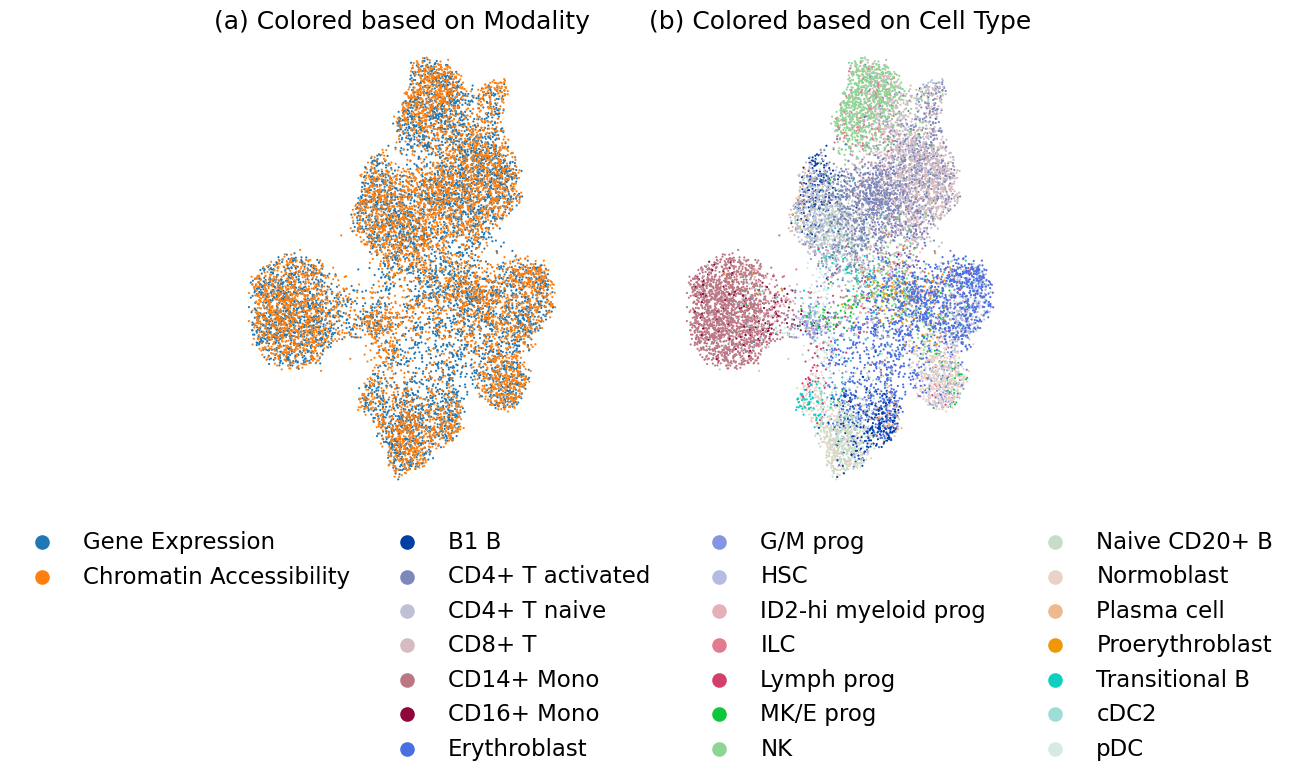

In [69]:
sc.pp.neighbors(adata, use_rep="X_coot")
sc.tl.umap(adata)

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'wspace': 0.3})

sc.pl.umap(adata, color=["batch_translated"], frameon=False, ax=ax1, show=False)
ax1.set_title("(a) Colored based on Modality")
ax1.get_legend().remove()

sc.pl.umap(adata, color=["cell_type"], frameon=False, ax=ax2, show=False)
ax2.set_title("(b) Colored based on Cell Type")
ax2.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

fig.legend(handles1, labels1, loc='lower left', ncol = 1, bbox_to_anchor=(-0.11, 0.165), frameon=False,)
fig.legend(handles2, labels2, loc='lower center', ncol=3, bbox_to_anchor=(0.72, -0.05), frameon=False)

fig.subplots_adjust(bottom=0.3)
fig.set_size_inches(10, 8)
#plt.savefig('./05_umap_coot.png', dpi=300, bbox_inches="tight")
plt.show()

# Confusion matrices

In [77]:
ys = rna.obs['cluster']
yt = atac.obs['cluster']

In [79]:
ys = np.array(rna.obs['cluster'])[:,None]
yt = np.array(atac.obs['cluster'])[:,None]

nbc = np.unique(ys).shape[0]
ntot = Ts.shape[0]

Cmat = np.zeros((nbc,nbc))

for i in tqdm(range(ntot)):
    for j in range(ntot):
        if Ts[i,j]:
            Cmat[int(ys[i]),int(yt[j])]+=Ts[i,j]
            
print('Find the correct cluster in {:.2f}% '.format(100*np.sum(np.diag(Cmat))))

100%|██████████| 6224/6224 [00:46<00:00, 135.23it/s]

Find the correct cluster in 26.29% 


In [94]:
ys = np.array(rna.obs['cluster'])[:,None]
yt = np.array(atac.obs['cluster'])[:,None]

nbc = np.unique(ys).shape[0]
ntot = T_ftp.shape[0]

Cmat_ftp = np.zeros((nbc,nbc))

for i in tqdm(range(ntot)):
    for j in range(ntot):
        if T_ftp[i,j]:
            Cmat_ftp[int(ys[i]),int(yt[j])]+=T_ftp[i,j]
            
print('Find the correct cluster in {:.2f}% '.format(100*np.sum(np.diag(Cmat_ftp))))

100%|██████████| 6224/6224 [00:50<00:00, 122.10it/s]

Find the correct cluster in 73.14% 


In [182]:
T_tp = np.array(tp[('src', 'tgt')].solution.transport_matrix)

In [183]:
ys = np.array(rna.obs['cluster'])[:,None]
yt = np.array(atac.obs['cluster'])[:,None]

nbc = np.unique(ys).shape[0]
ntot = T_tp.shape[0]

Cmat_tp = np.zeros((nbc,nbc))

for i in tqdm(range(ntot)):
    for j in range(ntot):
        if T_tp[i,j]:
            Cmat_tp[int(ys[i]),int(yt[j])]+=T_tp[i,j]
            
print('Find the correct cluster in {:.2f}% '.format(100*np.sum(np.diag(Cmat_tp))))

100%|██████████| 6224/6224 [00:42<00:00, 148.12it/s]

Find the correct cluster in 38.25% 


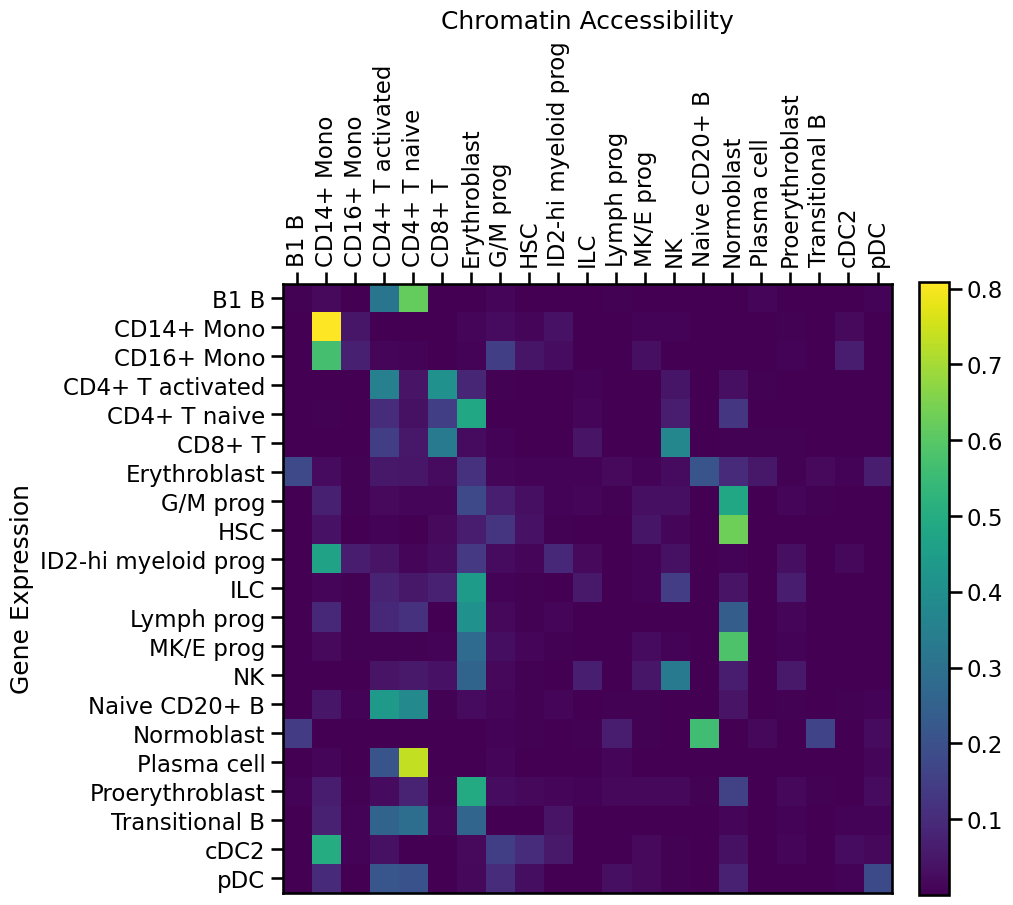

In [178]:
fig, ax = plt.subplots(1, 1, )#gridspec_kw={'wspace': 1})

im1 = ax.imshow(pp.normalize(Cmat, norm = 'l1', axis = 1))

ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set(xlabel='Chromatin Accessibility', ylabel='Gene Expression', 
       xticks=range(21), xticklabels = list(np.unique(rna.obs['cell_type'])), 
       yticks=range(21), yticklabels = list(np.unique(atac.obs['cell_type']))
      )
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
ax.xaxis.set_label_coords(0.5, 1.45)

plt.colorbar(im1,fraction=0.046, pad=0.04, shrink = 1.0)

set_size(fig, (10, 10))
plt.savefig('./05_coot_cell_transition.png', dpi=300, bbox_inches="tight")

plt.show()

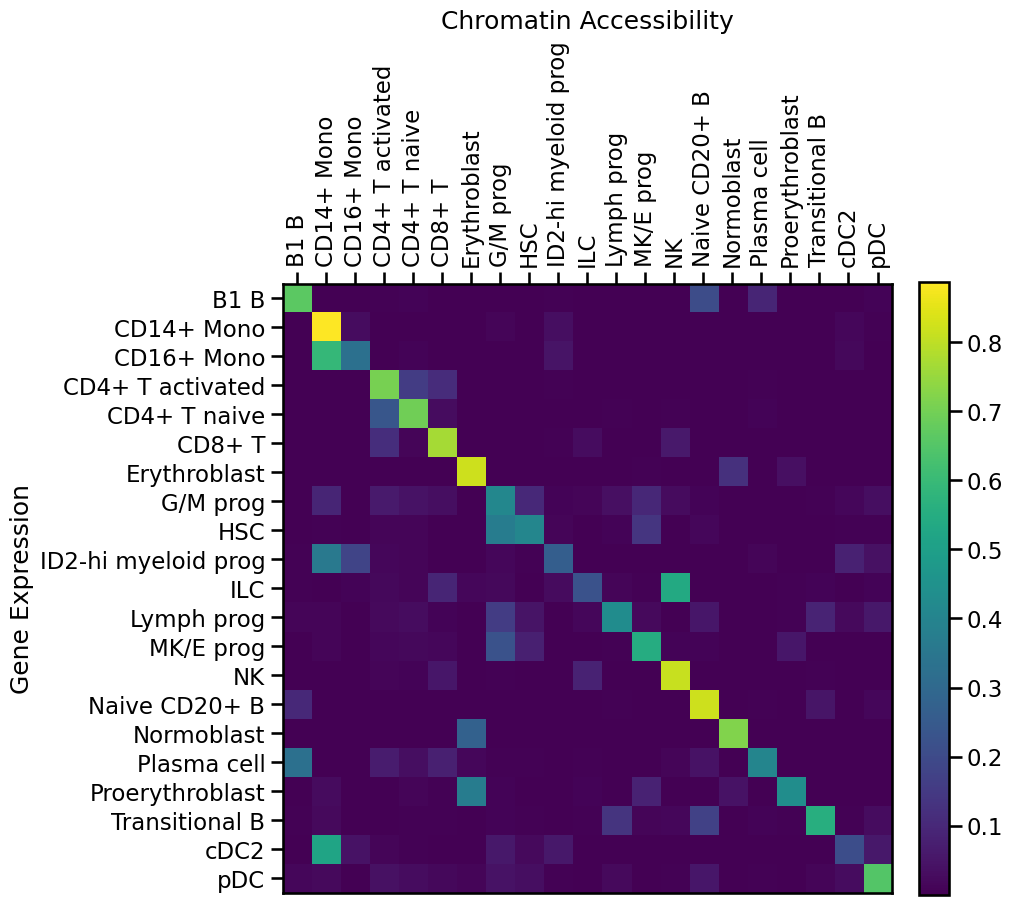

In [179]:
fig, ax = plt.subplots(1, 1, )#gridspec_kw={'wspace': 1})

im1 = ax.imshow(pp.normalize(Cmat_ftp, norm = 'l1', axis = 1))

ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set(xlabel='Chromatin Accessibility', ylabel='Gene Expression', 
       xticks=range(21), xticklabels = list(np.unique(rna.obs['cell_type'])), 
       yticks=range(21), yticklabels = list(np.unique(atac.obs['cell_type']))
      )
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
ax.xaxis.set_label_coords(0.5, 1.45)

plt.colorbar(im1,fraction=0.046, pad=0.04, shrink = 1.0)

set_size(fig, (10, 10))
plt.savefig('./05_ftp_cell_transition.png', dpi=300, bbox_inches="tight")

plt.show()

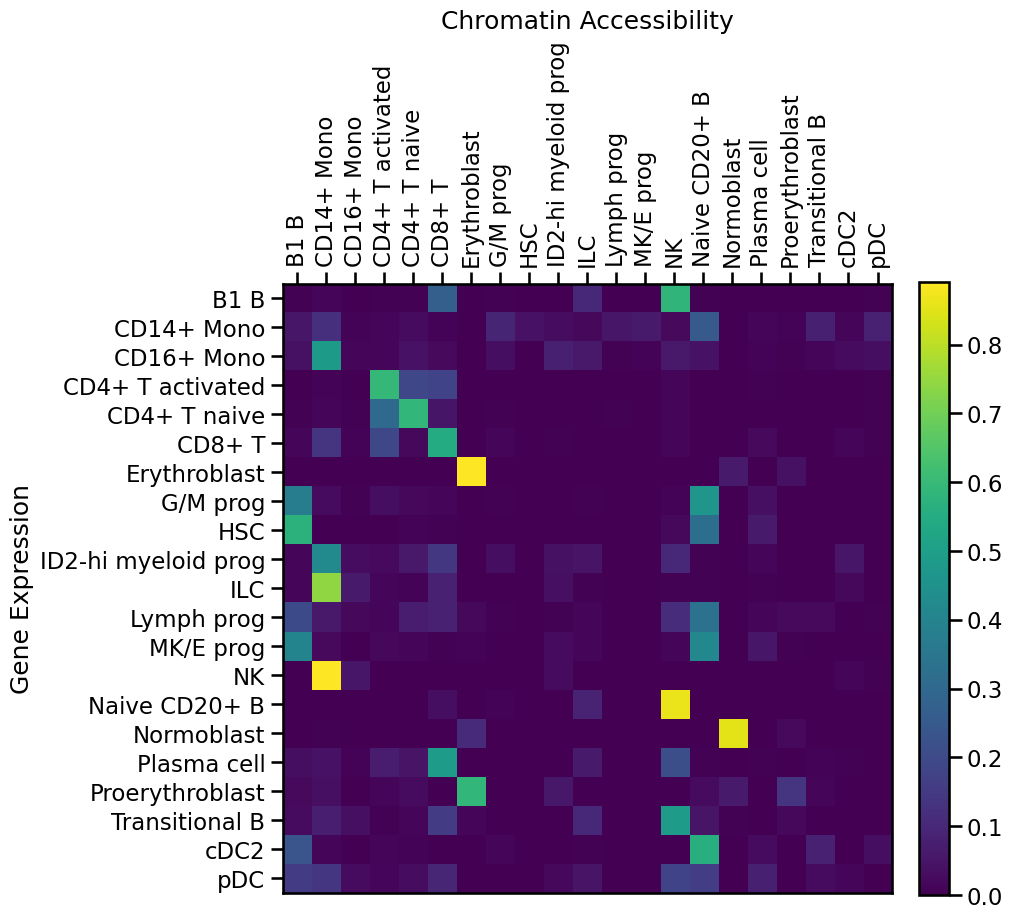

In [184]:
fig, ax = plt.subplots(1, 1, )#gridspec_kw={'wspace': 1})

im1 = ax.imshow(pp.normalize(Cmat_tp, norm = 'l1', axis = 1))

ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set(xlabel='Chromatin Accessibility', ylabel='Gene Expression', 
       xticks=range(21), xticklabels = list(np.unique(rna.obs['cell_type'])), 
       yticks=range(21), yticklabels = list(np.unique(atac.obs['cell_type']))
      )
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
ax.xaxis.set_label_coords(0.5, 1.45)

plt.colorbar(im1,fraction=0.046, pad=0.04, shrink = 1.0)

set_size(fig, (10, 10))
plt.savefig('./05_tp_cell_transition.png', dpi=300, bbox_inches="tight")

plt.show()